# Loading and Processing Data Generated by Simulation

This script is for loading data generated in the FASRC cluster from simulations of my agent-based ant model, and then doing stuff with that data. Doing stuff life: 1) visualizing the data (ant trajectories) and 2) creating summary figures and analysis graphs.

There are plenty of parameter analysis tests. Here is a list of the basic ones:

- AD (Agent Density): varies WH/N, with 
    - W=H=100 and 
    - N ranging over [1, 10, 50, 100, 500, 1000]
- AO (Agent Orientation): varies K_P vs theta_stochasticity, with 
    - K_P in [0.1, 0.25, 0.5, 0.75, 1] 
    - THETA_STOCH in [0, pi/16, pi/8, pi/4]
- AS1 (Agent Speed, test 1): varies SMIN vs SMAX/SMIN, with 
    - SMIN in [0, 2.5, 5, 7.5, 10]
    - SMAX/SMIN in [1, 2, 4, 6, 8]
- AS2 (Agent Speed, test 2): varies K_S vs SMAX/SMIN, with 
    - K_S in [0.1, 0.25, 0.5, 0.75, 1]
    - SMAX/SMIN in [1, 2, 4, 6, 8]
- PE1 (Pheromone Evolution, test 1): varies D vs E, with
    - D in [0.01, 0.05, 0.1, 0.2 ,0.4, 0.6, 0.8, 1]
    - E in [0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5]
- PE2 (Pheromone Evolution, test 2): varies D/E vs P_DROP, with
    - D=0.6 and E in [0.02, 0.1, 0.2, 0.4, 0.6]
    - P_DROP in [0.1, 0.25, 0.5, 0.75, 1]
- PE3 (Pheromone Evolution, test 3): varies M vs P_DROP
    - M in [1, 2.5, 5, 7.5, 10, 15]
    - P_DROP in [0, 0.1, 0.25, 0.5, 0.75, 1]
- PS (Pheromone Sensitivity): varies M vs MIN_PH_SENS, WITH
    - M in [1, 2.5, 5, 10]
    - MIN_PH_SENS in [0, 0.1, 0.2, 0.4]

## Data File

In [26]:
data_file = "data/data_AD_7x1.txt"

## Load Data

In [27]:
import json

with open(data_file, 'r') as f:
    # Read the first line which contains the dictionary
    dictionary_str = f.readline().strip()

    # Convert the string representation of dictionary to a Python dictionary
    data = json.loads(dictionary_str)

## Print Some Data

In [5]:
len(data['0.1']['0.0001']['r1'])

KeyError: '0.0001'

## Visualize Ant Trajectories

In [9]:
import pygame
import random

# simulation and visualization dimensions
sim_w, sim_h = 100, 100
cell_size = 5
vis_w, vis_h = cell_size*sim_w, cell_size*sim_h

pygame.init()
screen = pygame.display.set_mode((vis_w,vis_h))
pygame.display.set_caption("Simulation")

# fill the screen with white
screen.fill((255, 255, 255))

ant_locations_transposed = [[(x * cell_size, y * cell_size) for x, y in row] for row in zip(*data['0.6']['0.01']['r1'][2500:3000])]

for ant in ant_locations_transposed:
    pygame.draw.lines(screen, (random.uniform(0,200),random.uniform(0,200),random.uniform(0,200)), False, ant)

pygame.display.update()

## Summary Parameter

In [28]:
# Method for printing nested dictionaries in a nice format.
def print_nested_dictionary(dictionary, indent=0):
    for key, value in dictionary.items():
        if isinstance(value, dict):
            print('\t' * indent + f"{key}:")
            print_nested_dictionary(value, indent + 1)
        else:
            print('\t' * (indent) + f"{key}: {value}")

In [46]:
import numpy as np
from statistics import mean
from scipy.cluster.hierarchy import linkage,fcluster
from scipy.spatial import ConvexHull

# Define summary analysis parameter.
# Example: Calculate the mean of the data_list
def summary_analysis_function(data_trial):
    order_parameters = []
    for rep, trajectories in data_trial.items():
        count = 0
        for frame in trajectories:
            if count % 1 == 0:
                order_parameters.append(calculate_cluster_area_order(frame, 100*100, 4))
            count += 1
    time = np.arange(len(order_parameters))
    smoothed_time, smoothed_parameters = smooth(time,order_parameters,50)
    return (mean(smoothed_parameters[-50:]) - mean(smoothed_parameters[0:5])) / mean(smoothed_parameters[0:5]) #(smoothed_parameters[-1] - smoothed_parameters[0]) / smoothed_parameters[0]

def calculate_cluster_area_order(centroids, frame_area, num_clusters = 9):
    if len(centroids) <= 2:
        return 0
    X = np.array(centroids)
    Z = linkage(X,'centroid')
    cluster_assignments = fcluster(Z,num_clusters,'maxclust')
    
    total_area = 0
    for i in range(max(cluster_assignments)):
        idxs = [idx for idx,x in enumerate(cluster_assignments) if x == i+1]
        cluster_points = [p for idx,p in enumerate(X) if idx in idxs]
        if(len(cluster_points) < 3):
            continue
        try:
            total_area += (ConvexHull(cluster_points)).volume
        except:
            continue
    
    return total_area/frame_area

def smooth(time,data,window_size):
    data_s = np.convolve(data, np.ones(window_size)/window_size, mode='valid')
    time_s = time[(window_size-1)//2 : -(window_size-1)//2]
    return time_s,data_s

### Create Summary Parameter Array

In [30]:
# With average order parameter, at intervals of 5.

# # One way.
# summary_analysis = {
#     A_value: {
#         B_value: summary_analysis_function(data_list)
#         for B_value, data_list in dataset.items()
#     }
#     for A_value, dataset in original_dataset.items()
# }

# Another way.
summary_param = {}
for A_k,A_t in data.items():
    summary_param[float(A_k)] = {}
    for B_k,B_t in A_t.items():
        summary_param[float(A_k)][float(B_k)] = summary_analysis_function(B_t)

# Print parameter nicely.
print_nested_dictionary(summary_param)

AttributeError: 'list' object has no attribute 'items'

In [47]:
# For AD (single parameter analysis).

summary_param = {}
for A_k,A_t in data.items():
    summary_param[float(A_k)] = summary_analysis_function(A_t)

# Print parameter nicely.
print_nested_dictionary(summary_param)

/Users/xavier/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


1.0: nan
10.0: 0.14639168585299747
50.0: -0.9910791415127775
100.0: -0.8508246077958197
500.0: -0.7126392262052622
1000.0: -0.428338517305367


In [48]:
summary_param[1.0] = 0

In [11]:
summary_param = {4:1, 10:2, 50:3, 100:4, 500:5, 1000:6}

### Draw Graph of Summary Parameter

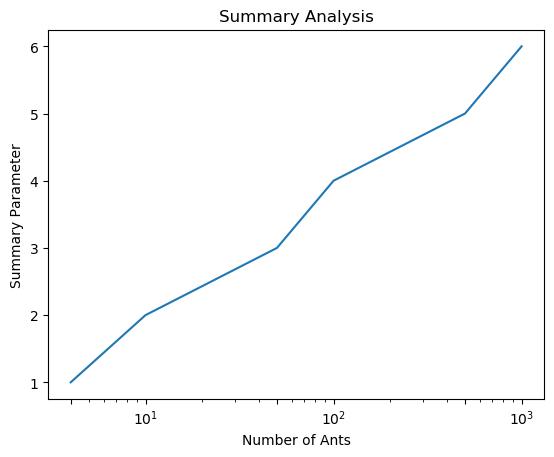

In [14]:
# For AD (single parameter analysis).

import matplotlib.pyplot as plt
import numpy as np

summary_analysis = summary_param

# Extract parameters and summary parameters
params_A = sorted(summary_analysis.keys())  # Sort the keys
summary_parameters = [summary_analysis[A] for A in params_A]

# Determine the overall minimum and maximum values of summary parameters
min_value = min(summary_parameters)
max_value = max(summary_parameters)

fig, ax = plt.subplots()
ax.plot(params_A, summary_parameters)

# ax.set_xscale('log')

# # Customize the plot
ax.set_xticks(params_A)
ax.set_xlabel('Number of Ants')
ax.set_ylabel('Summary Parameter')
ax.set_title('Summary Analysis')

plt.show()

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Example summary analysis data
summary_analysis = {
    1.0: {1.0: 0.2, 2.0: 0.5, 3.0: 0.8},
    5.0: {1.0: 0.4, 2.0: 0.6, 3.0: 0.7},
    7.0: {1.0: 0.1, 2.0: 0.3, 3.0: 0.9}
}
summary_analysis = summary_param

# Extract parameters and summary parameters
params_A = sorted(summary_analysis.keys())  # Sort the keys
params_B = sorted(summary_analysis[params_A[0]].keys())  # Sort the keys
summary_parameters = [[summary_analysis[A][B] for B in params_B] for A in params_A]

# Determine the overall minimum and maximum values of summary parameters
min_value = min(min(row) for row in summary_parameters)
max_value = max(max(row) for row in summary_parameters)

# Create a colormap
cmap = plt.get_cmap('viridis')  # You can choose any colormap you like

# # Plot the data
# fig, ax = plt.subplots()
# for i, A in enumerate(params_A):
#     for j, B in enumerate(params_B):
#         color = cmap((summary_parameters[i][j] - min_value) / (max_value - min_value)) #cmap(summary_parameters[i][j])
#         ax.scatter(A, B, color=color)

# # Customize the plot
# ax.set_xticks(params_A)
# ax.set_yticks(params_B)
# ax.set_xlabel('Parameter D')
# ax.set_ylabel('Parameter E')
# ax.set_title('Summary Analysis')

# # Show colorbar
# sm = plt.cm.ScalarMappable(cmap=cmap)
# sm.set_array([])
# plt.colorbar(sm, ax=ax)

# Create meshgrid of parameter values
A_values, B_values = np.meshgrid(params_A, params_B)

# Create 2D grid of color values and transpose it.
color_values_grid = np.array(summary_parameters)
color_values_grid = np.transpose(color_values_grid)

# Define the desired range for color mapping.
vmin = -0.2  # Minimum value
vmax = 0.04  # Maximum value

# Plot the data
fig, ax = plt.subplots()
color_map = ax.imshow(color_values_grid, extent=[min(params_A), max(params_A), min(params_B), max(params_B)], cmap='viridis', aspect='auto', origin='lower', vmin=vmin, vmax=vmax)

# Customize the plot
ax.set_xlabel('Parameter D')
ax.set_ylabel('Parameter E')
ax.set_title('Summary Analysis')

# Show colorbar
plt.colorbar(color_map, ax=ax)

plt.show()

AttributeError: 'int' object has no attribute 'keys'

# Getting Data Samples and Visualizing Them

In [ ]:
import json

data_file = "data_AS2_5x6x3.txt"

with open(data_file, 'r') as f:
    # Read the first line which contains the dictionary
    dictionary_str = f.readline().strip()

    # Convert the string representation of dictionary to a Python dictionary
    data = json.loads(dictionary_str)
    

with open("K_0.1_S_40.txt", 'w') as f:
    f.write(json.dumps(data['0.1']['40']['r1']))
    
with open("K_0.1_S_8.txt", 'w') as f:
    f.write(json.dumps(data['0.1']['8']['r1']))
    
with open("K_1_S_40.txt", 'w') as f:
    f.write(json.dumps(data['1']['40']['r1']))

## Visualizing Data Samples

In [23]:
import json

data_file = "data_samples/K_0.1_S_8.txt"

with open(data_file, 'r') as f:
    # Read the first line which contains the dictionary
    dictionary_str = f.readline().strip()

    # Convert the string representation of dictionary to a Python dictionary
    data = json.loads(dictionary_str)

In [24]:
import pygame
import random

# simulation and visualization dimensions
sim_w, sim_h = 100, 100
cell_size = 5
vis_w, vis_h = cell_size*sim_w, cell_size*sim_h

pygame.init()
screen = pygame.display.set_mode((vis_w,vis_h))
pygame.display.set_caption("Simulation")

# fill the screen with white
screen.fill((255, 255, 255))

ant_locations_transposed = [[(x * cell_size, y * cell_size) for x, y in row] for row in zip(*data[-25:-1])]
ant_final_locations = data[-1] #[[(x * cell_size, y * cell_size) for x, y in row] for row in zip(*data[-1])]
for ant in ant_locations_transposed:
    pygame.draw.lines(screen, (random.uniform(0,200),random.uniform(0,200),random.uniform(0,200)), False, ant)

for ant in ant_final_locations:
    pygame.draw.rect(screen, 'black', pygame.Rect(5*ant[0],5*ant[1],5,5))

pygame.display.update()

In [10]:
data[2995:-1]

[[[38.5924900573334, 92.30763623712136],
  [59.16252013032123, 37.43818361126575],
  [61.58308764969536, 37.66253546606273],
  [54.123821059105246, 55.780217557486665],
  [55.98958453347796, 54.006231979448216],
  [60.19247514157954, 38.76308235555742],
  [54.9285615572069, 53.65297038357783],
  [42.23871841051009, 89.51320366046393],
  [60.00055378787298, 35.25346723338486],
  [69.26653271902826, 7.588118644793652],
  [57.28793119974101, 54.636163452634015],
  [57.45217631397257, 40.53516226803378],
  [51.406589019154715, 56.57996128343511],
  [42.58517382081409, 92.46393959111664],
  [52.46145270543682, 54.53858431689171],
  [56.10654008967631, 52.139953952996045],
  [59.49518036858025, 38.79700616703469],
  [40.941277022317465, 91.73238126192688],
  [59.98154070802816, 39.55391554522871],
  [61.946438301368055, 37.073795345890495],
  [59.959309273509405, 35.77396521069166],
  [55.378190259943054, 58.01249922198516],
  [56.616747458361004, 53.28273427091421],
  [54.60094027353251, 51

###